In [ ]:
import os
import pandas as pd
import numpy as np
import ruptures as rpt

def apply_change_point_detection(data, columns=['AccV', 'AccML', 'AccAP'], pen=50):

    # Perform change point detection for each signal column
    for col in columns:
        signal = data[col].values
        algo = rpt.Pelt(model="rbf").fit(signal)
        result = algo.predict(pen=pen)
        print(result)

        # Update the corresponding 'd' columns with 1 between start and end times
        for start, end in zip(result[:-1], result[1:]):
            data.loc[data['Time'].between(start, end), 'd' + col] = 1
                
    return data

def load_and_combine_data(path):
    data_list = []
    folders = ['tdcsfog', 'defog', 'notype']

    for folder in folders:
        folder_path = os.path.join(path, folder)
        # counter = 0
        for file in os.listdir(folder_path):
            # counter += 1
            file_path = os.path.join(folder_path, file)
            data = pd.read_csv(file_path)
            data['Source'] = folder
            data['SeriesId'] = file.split('.')[0]# Use the filename (without the extension) as the SeriesId
            # data[['dAccV', 'dAccML', 'dAccAP']] = 0
            # data = apply_change_point_detection(data)
            # print(f'File number: {counter}')
            data_list.append(data)

    combined_data = pd.concat(data_list, ignore_index=True)
    return combined_data

def unify_sampling_rate(data):
    # Interpolate defog and notype data from 100Hz to 128Hz
    def interpolate_data(df):
        df['Time'] = pd.to_timedelta(df['Time'], unit='ms')  # Convert 'Time' column to timedelta
        df_resampled = df.set_index('Time').resample('7.8125ms').interpolate(method='linear').reset_index()
        return df_resampled

    data_defog = data[data['Source'].isin(['defog', 'notype'])].groupby('SeriesId').apply(interpolate_data).reset_index(drop=True)
    data_tdcsfog = data[data['Source'] == 'tdcsfog']

    unified_data = pd.concat([data_tdcsfog, data_defog], ignore_index=True)
    return unified_data


def unify_acceleration_units(data):
    g_to_ms2 = 9.81

    data.loc[data['Source'].isin(['defog', 'notype']), ['AccV', 'AccML', 'AccAP']] *= g_to_ms2
    return data

def filter_data(data):
    filtered_data = data[(data['Valid'].fillna(True)) & (data['Task'].fillna(True))].reset_index(drop=True)
    return filtered_data

data_path = "./train/"
data = load_and_combine_data(data_path)
# data = unify_sampling_rate(data)
data = unify_acceleration_units(data)
filtered_data = filter_data(data)
filtered_data[['dAccV', 'dAccML', 'dAccAP']] = 0
filtered_data = filtered_data[['AccV', 
                               'AccML', 
                               'AccAP', 
                               'StartHesitation', 
                               'Turn', 
                               'Walking',
                               'SeriesId',
                               'Time',
                               'dAccV',
                               'dAccML',
                               'dAccAP',
                              ]]

filtered_data.to_csv('filtered.csv', index=False)

In [26]:
import ruptures as rpt
import pandas as pd

def apply_change_point_detection(data, columns=['AccV', 'AccML', 'AccAP'], pen=200):

    # Iterate through the unique SeriesId values
    for series_id in data['SeriesId'].unique():
        # Extract the data for the current SeriesId
        series_data = data[data['SeriesId'] == series_id]
        if len(series_data) > 9000:
            downsample_factor = 10  # Modify this value to change the downsampling rate
        if len(series_data) < 9000:
            downsample_factor = 5
        downsampled_data = series_data.iloc[::downsample_factor, :].reset_index(drop=True)

        for col in columns:
            signal = downsampled_data[col].values
            algo = rpt.Pelt(model="rbf", jump=200).fit(signal)
            result = algo.predict(pen=pen)
            print(result)

            if len(result) > 1:
                for idx, (start, end) in enumerate(zip(result[:-1], result[1:])):
                    if idx % 2 == 0:
                        start_original = start * downsample_factor
                        end_original = end * downsample_factor
                        data.loc[(data['SeriesId'] == series_id) & data['Time'].between(start_original, end_original - 1), 'd' + col] = 1

                # Check if there's an odd number of change points and if the last one is within 20% of the end of the data
                if len(result) % 2 == 1 and result[-1] >= (0.8 * len(downsampled_data)):
                    start_original = result[-1] * downsample_factor
                    end_original = len(series_data)
                    data.loc[(data['SeriesId'] == series_id) & data['Time'].between(start_original, end_original - 1), 'd' + col] = 1

    return data


test_data = pd.read_csv('./train/defog/02ea782681.csv')
test_data['SeriesId'] = '02ea782681'
test_data[['dAccV', 'dAccML', 'dAccAP']] = 0
test_data = test_data[['AccV', 
                       'AccML', 
                       'AccAP', 
                       'StartHesitation', 
                       'Turn', 
                       'Walking',
                       'SeriesId',
                       'Time',
                       'dAccV',
                       'dAccML',
                       'dAccAP',
                      ]]

test_data = apply_change_point_detection(test_data, pen=200)


162907
[8000, 11600, 16291]


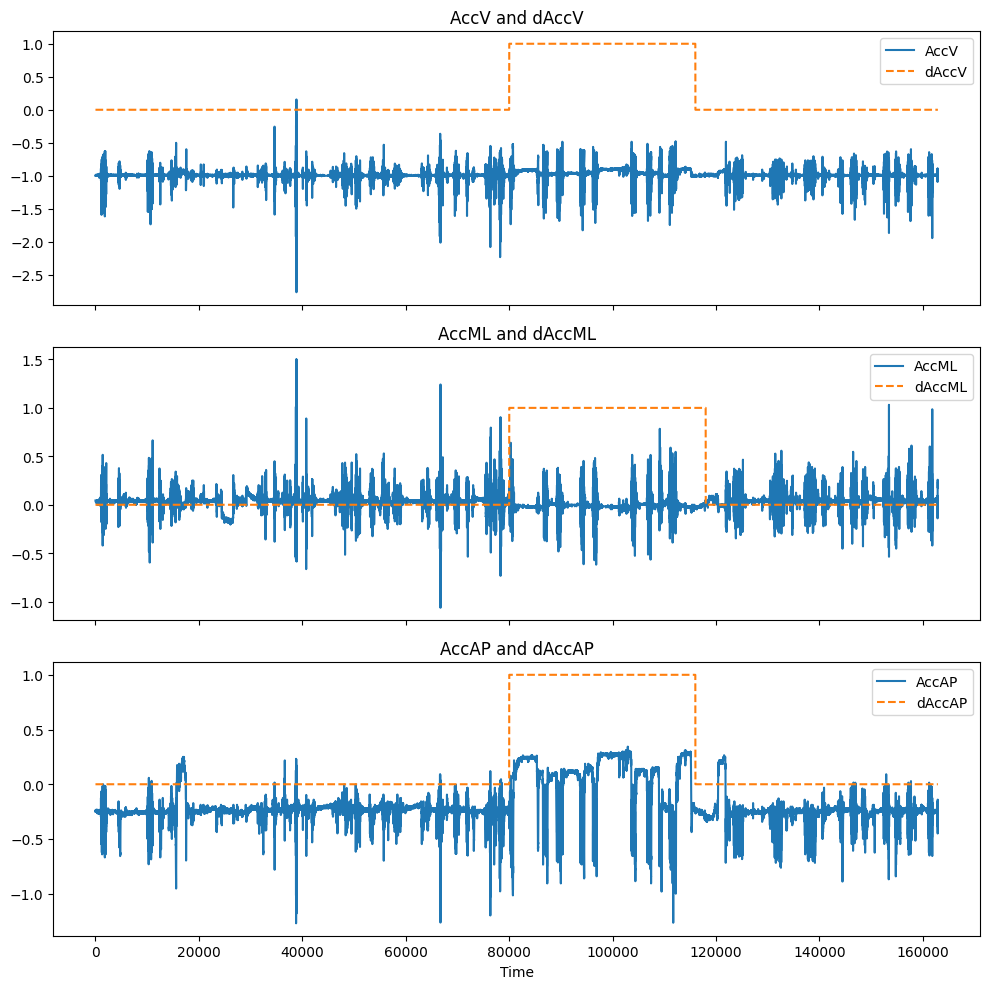

In [24]:
import matplotlib.pyplot as plt

# Assuming test_data is a DataFrame containing the acceleration and change point detection data
fig, axes = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

axes[0].plot(test_data["Time"], test_data["AccV"], label="AccV")
axes[0].plot(test_data["Time"], test_data["dAccV"], label="dAccV", linestyle="--")
axes[0].set_title("AccV and dAccV")
axes[0].legend()

axes[1].plot(test_data["Time"], test_data["AccML"], label="AccML")
axes[1].plot(test_data["Time"], test_data["dAccML"], label="dAccML", linestyle="--")
axes[1].set_title("AccML and dAccML")
axes[1].legend()

axes[2].plot(test_data["Time"], test_data["AccAP"], label="AccAP")
axes[2].plot(test_data["Time"], test_data["dAccAP"], label="dAccAP", linestyle="--")
axes[2].set_title("AccAP and dAccAP")
axes[2].legend()

plt.xlabel("Time")
plt.tight_layout()
plt.show()
